# Re-using a trained flow

We will see how to simply store, reload and reuse a flow obtained after an initial run of `flowMC`. 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp  
from jax.scipy.special import logsumexp

Let's consider a simple 2d mixture of Gaussian as an objective and 

/tmp/ipykernel_146315/2633405322.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(x_range, y_range, np.exp(log_prob), 20, cmap=cm.get_cmap('magma_r'))


(-3.0, 3.0, -3.0, 3.0)

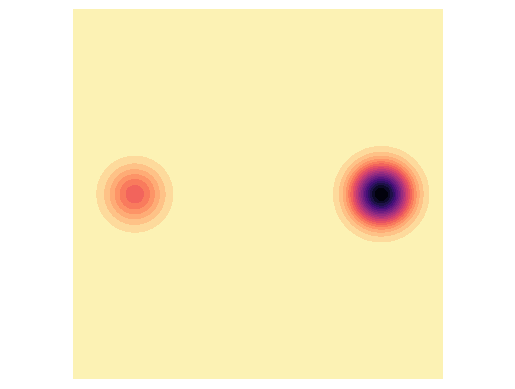

In [8]:
n_dim = 2
sep = 2
weight = 3
var = 0.1

def log_prob_mixture(x, data=None):
    term1 = - 0.5 * (jnp.linalg.norm(x - jnp.array([- sep, 0]))) ** 2 / var
    term2 = - 0.5 * (jnp.linalg.norm(x - jnp.array([+ sep, 0]))) ** 2 / var + jnp.log(weight)
    return logsumexp(jnp.stack([term1, term2]), axis=-1)

vmap_log_prob_mixture = jax.vmap(log_prob_mixture)

import matplotlib.pyplot as plt
from matplotlib import cm
n_points = 100
lim = sep * (1 + 5 * var)
x_range = np.linspace(-lim, lim, n_points)
y_range = np.linspace(-lim, lim, n_points)
grid = np.meshgrid(x_range, y_range)
xys = np.stack(grid).reshape(2, n_points ** 2).T
log_prob = vmap_log_prob_mixture(xys).reshape(n_points, n_points)
plt.contourf(x_range, y_range, np.exp(log_prob), 20, cmap=cm.get_cmap('magma_r'))
plt.axis('equal')
plt.axis('off')

## Running `flowMC.sampler.Sampler` once with training

In [9]:
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler

# Init
n_chains = 20
rng_key_set = initialize_rng_keys(n_chains, seed=42)

# Flow
n_layer = 10  # number of coupling layers
n_hidden = 128  # with of hidden layers in MLPs parametrizing coupling layers

## To use instead the more powerful RQSpline:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
model = MaskedCouplingRQSpline(n_dim, 4, [32,32], 8 , jax.random.PRNGKey(10))


# Local sampler
step_size = 1e-1
MALA_Sampler = MALA(log_prob_mixture, True, {"step_size": step_size})

# Global-local sampler
n_loop_training = 30
n_loop_production = 0
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    jnp.zeros(5),
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

jit is requested, precompiling kernels and update...


In [11]:
initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1
nf_sampler.sample(initial_position, None)
out_train = nf_sampler.get_sampler_state(training=True)
print('Logged during tuning:', out_train.keys())

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


Starting Production run


Production run: 0it [00:00, ?it/s]

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


Let's make sure we had a successful first run:

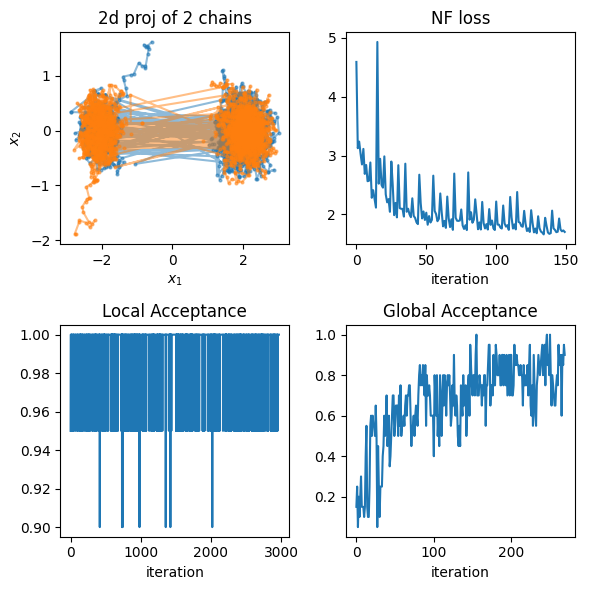

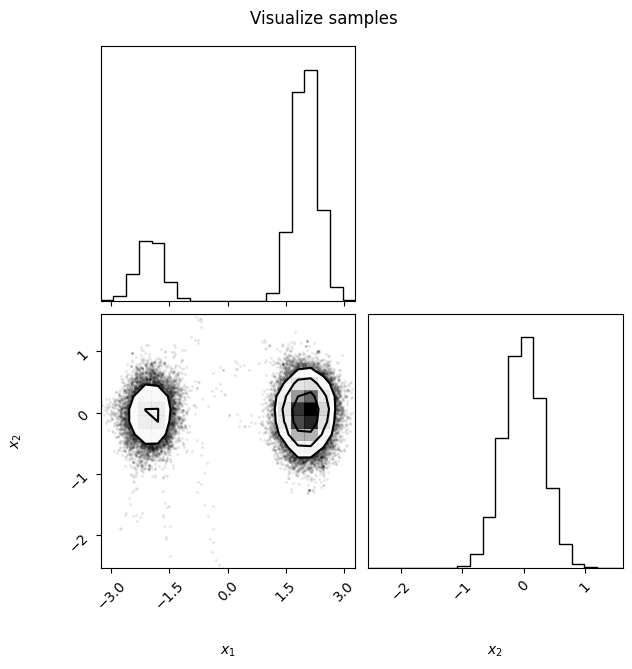

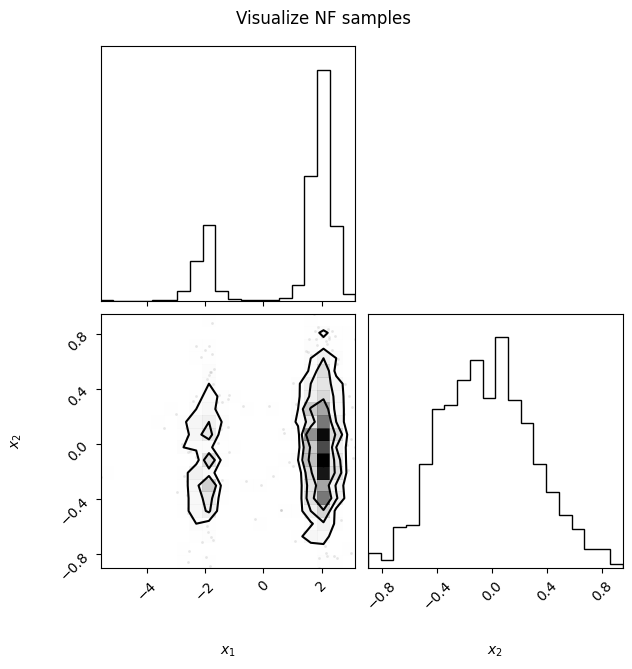

In [13]:
import corner
import matplotlib.pyplot as plt

chains = np.array(out_train['chains'])
global_accs = np.array(out_train['global_accs'])
local_accs = np.array(out_train['local_accs'])
loss_vals = np.array(out_train['loss_vals'])
nf_samples = np.array(nf_sampler.sample_flow(1000))


# Plot 2 chains in the plane of 2 coordinates for first visual check 
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()


Acceptance of global move proposed by the flow is significant and here we can check that the samples produced by the flow are highly correlated with the target. we may want to save the parameters of the flow for later use. 

In [15]:
nf_sampler.save_flow("best_model")

## Loading parameters and running the `flowMC` sampler again

In [26]:
n_loop_production = 5

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    jnp.zeros(5),
    MALA_Sampler,
    model,
    n_loop_training=0,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)
nf_sampler.load_flow("./best_model")

jit is requested, precompiling kernels and update...


In [27]:
initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1
nf_sampler.sample(initial_position, None)
out_prod = nf_sampler.get_sampler_state()
print('Logged in production:', out_prod.keys())

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler: 0it [00:00, ?it/s]


Starting Production run


Production run: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]

Logged in production: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


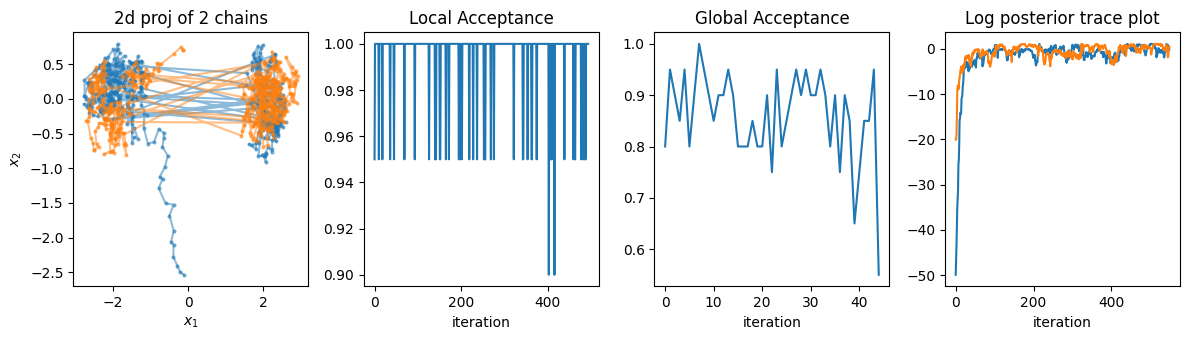

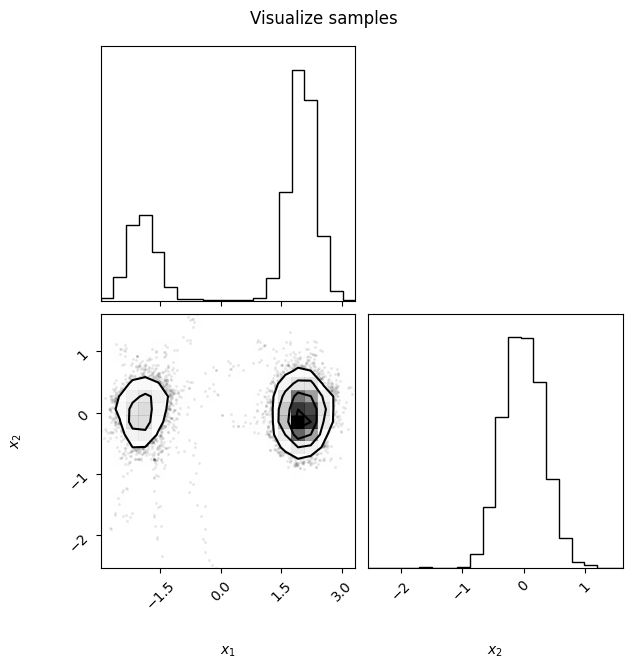

In [29]:
chains = np.array(out_prod['chains'])
index = 7 # choosing random chain index to plot results
global_accs = np.array(out_prod['global_accs'])
local_accs = np.array(out_prod['local_accs'])
log_prob_trace = np.array(out_prod['log_prob'][np.array([index,index+10]),:]).T

plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[index, :, 0], chains[index, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[index+10, :, 0], chains[index+10, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Log posterior trace plot")
plt.plot(log_prob_trace)
plt.xlabel("iteration")

plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)


As the flow was already trained in the previous run, we can see that the global acceptance is instantaneously high and the chains will mix extremely fast. 